In [1]:
import trt_pose
import trt_pose.coco
import json

In [2]:
# Import topology
with open('/root/trt_pose/tasks/human_pose/human_pose.json', 'r') as f: 
    human_pose = json.load(f)

# Import topology 
topology = trt_pose.coco.coco_category_to_topology(human_pose) 

In [3]:
import trt_pose.models

num_parts = len(human_pose['keypoints'])
num_links = len(human_pose['skeleton'])

model = trt_pose.models.resnet18_baseline_att(num_parts, 2 * num_links).cuda().eval()

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
import torch
MODEL_WEIGHTS = '/root/trt_pose/tasks/human_pose/resnet18_baseline_att_224x224_A_epoch_249.pth'

model.load_state_dict(torch.load(MODEL_WEIGHTS))

<All keys matched successfully>

In [5]:
WIDTH = 224
HEIGHT = 224

data = torch.zeros((1, 3, HEIGHT, WIDTH)).cuda()

In [ ]:
import torch2trt

In [ ]:
model_trt = torch2trt.torch2trt(model, [data], fp16_mode=True, max_workspace_size=1<<25)

In [ ]:
OPTIMIZED_MODEL = 'resnet18_baseline_att_224x224_A_epoch_249_trt.pth'
torch.save(model_trt.state_dict(), OPTIMIZED_MODEL)

In [8]:
from torch2trt import TRTModule

OPTIMIZED_MODEL = '/root/trt_pose/tasks/human_pose/resnet18_baseline_att_224x224_A_epoch_249_trt.pth'
model_trt = TRTModule()
model_trt.load_state_dict(torch.load(OPTIMIZED_MODEL))

<All keys matched successfully>

In [15]:
import time 

t0 = time.time()
torch.cuda.current_stream().synchronize()
for i in range(50): 
    y = model_trt(data)
torch.cuda.current_stream().synchronize()
t1 = time.time()
print("DIFF: {}".format(t1-t0))
print(50.0/(t1-t0))

DIFF: 0.33950161933898926
147.27470254000602


In [16]:
import cv2
import torchvision.transforms as transforms
import PIL.Image

mean = torch.Tensor([0.485, 0.456, 0.406]).cuda()
std = torch.Tensor([0.229, 0.224, 0.225]).cuda()
device = torch.device('cuda')

def preprocess(image):
    global device
    device = torch.device('cuda')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = PIL.Image.fromarray(image)
    image = transforms.functional.to_tensor(image).to(device)
    image.sub_(mean[:, None, None]).div_(std[:, None, None])
    return image[None, ...]


In [17]:
from trt_pose.draw_objects import DrawObjects
from trt_pose.parse_objects import ParseObjects

parse_objects = ParseObjects(topology)
draw_objects = DrawObjects(topology)

## Necessary to use jetcam package 

Find [jetcam](https://github.com/NVIDIA-AI-IOT/jetcam). 

In [18]:
import sys
# Dirty hack to add camera
sys.path.insert(-1, "/usr/lib/python3.8/site-packages/jetcam-0.0.0-py3.8.egg")

In [32]:
from jetcam.usb_camera import USBCamera
# from jetcam.csi_camera import CSICamera
from jetcam.utils import bgr8_to_jpeg

camera = USBCamera(width=WIDTH, height=HEIGHT, capture_fps=30)
# camera = CSICamera(width=WIDTH, height=HEIGHT, capture_fps=30)

camera.running = True



ImportError: cannot import name 'jpeg_to_bgr8' from 'jetcam.utils' (/usr/lib/python3.8/site-packages/jetcam-0.0.0-py3.8.egg/jetcam/utils.py)

In [20]:
image = camera.read()

RuntimeError: Cannot read directly while camera is running

In [22]:
import ipywidgets
from IPython.display import display

image_widget = ipywidgets.Image(format='jpeg')

image_widget.value = bgr8_to_jpeg(image)

display(image_widget)

NameError: name 'image' is not defined

In [23]:
def execute(change):
    image = change['new']
    data = preprocess(image)
    cmap, paf = model_trt(data)
    cmap, paf = cmap.detach().cpu(), paf.detach().cpu()
    counts, objects, peaks = parse_objects(cmap, paf)#, cmap_threshold=0.15, link_threshold=0.15)
    draw_objects(image, counts, objects, peaks)
    image_widget.value = bgr8_to_jpeg(image[:, ::-1, :])



In [24]:
execute({'new': camera.value})


In [25]:
camera.observe(execute, names='value')

In [42]:
import numpy as np
import matplotlib.pyplot as plt


img = np.asarray(image_widget.value)
print(img.shape) 

jpeg_bytes = bytes(image_widget.value)
# Decode the JPEG bytes to an image using OpenCV
nparr = np.frombuffer(jpeg_bytes, np.uint8)
image = cv2.imdecode(nparr, cv2.IMREAD_COLOR)

(22026,)


In [21]:
camera.unobserve_all()

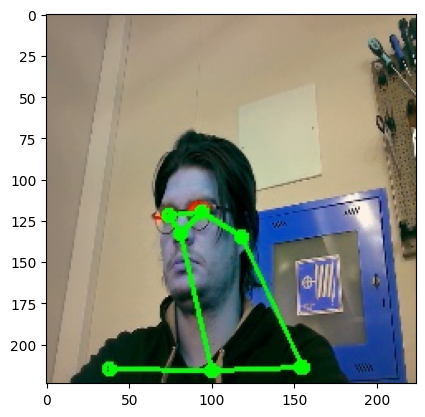

In [43]:
plt.imshow(image)